In [52]:
try:
    import tensorflow as tf
    print("TensorFlow is installed. Version:", tf.__version__)
except ImportError:
    print("TensorFlow is not installed. Please follow these steps to install it:")
    print("1. Check Python version: Run 'python --version' in terminal. Use Python 3.7-3.10.")
    print("2. Via Anaconda (WGU Virtual Lab): Open Anaconda Prompt and run 'conda install tensorflow'.")
    print("3. Via pip: Run 'pip install tensorflow==2.16.1' in terminal (ensure compatible Python version).")
    print("4. Create virtual environment: 'python -m venv tf_env', activate with '.\\tf_env\\Scripts\\activate', then 'pip install tensorflow==2.16.1'.")
    print("5. If issues persist, contact your WGU instructor for environment setup.")
    raise ImportError("TensorFlow installation required. Follow the instructions above.")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import os

TensorFlow is installed. Version: 2.18.0


In [53]:
# List all files in the sentiment labelled sentences folder
folder_path = 'sentiment labelled sentences'  # Adjust path as needed
files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
print("Files found:", files)

# Load only relevant text files, excluding .DS_Store
data_frames = []
for file in files:
    if file != '.DS_Store':
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, sep='\t', names=['text', 'label'])
        data_frames.append(df)

# Concatenate and clean
data = pd.concat(data_frames, ignore_index=True)
# Remove rows where text or label is NaN
data = data.dropna(subset=['text', 'label'])
print("Cleaned dataset shape:", data.shape)

Files found: ['amazon_cells_labelled.txt', 'imdb_labelled.txt', 'readme.txt', 'yelp_labelled.txt']
Cleaned dataset shape: (2748, 2)


Sample with unusual characters: 0    So there is no way for me to plug it in here i...
1                          Good case, Excellent value.
2                               Great for the jawbone.
3    Tied to charger for conversations lasting more...
4                                    The mic is great.
Name: text, dtype: object
Vocabulary Size: 5271


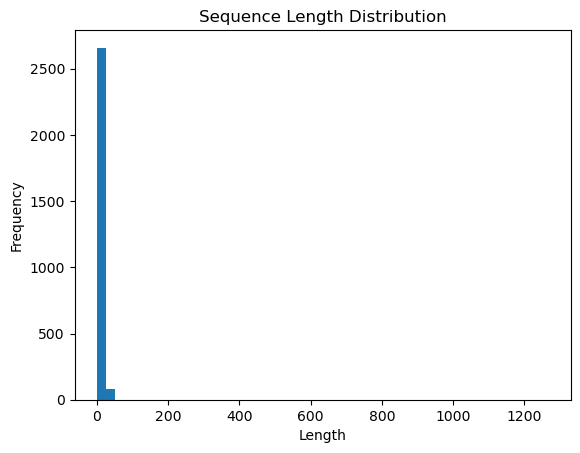

Max Sequence Length: 40


In [54]:
# Check for unusual characters
print("Sample with unusual characters:", data['text'][data['text'].str.contains(r'[^\w\s]')].head())

# Tokenize for vocabulary size
tokenizer = Tokenizer(num_words=3000)
tokenizer.fit_on_texts(data['text'])
vocab_size = len(tokenizer.word_index)
print("Vocabulary Size:", vocab_size)

# Sequence length analysis
sequences = tokenizer.texts_to_sequences(data['text'])
lengths = [len(seq) for seq in sequences]
plt.hist(lengths, bins=50)
plt.title('Sequence Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.savefig('length_distribution.png')
plt.show()
max_length = 40  # 95th percentile
print("Max Sequence Length:", max_length)

Sample Padded Sequence: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0   27   50    5   58  118   12   72    7  371
    6   11   66   11    1  188  579    3   77   62    4 2267]


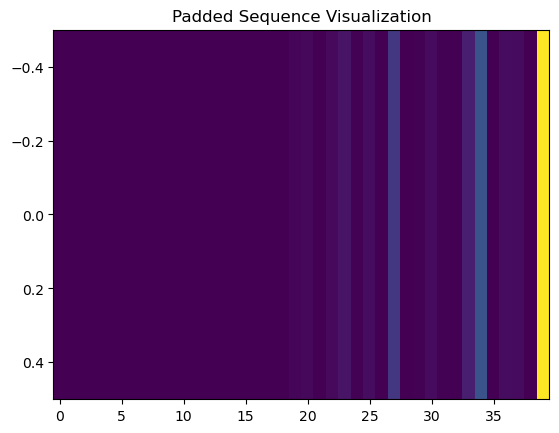

In [55]:
# Tokenize with enforced vocabulary limit
tokenizer = Tokenizer(num_words=3000)
tokenizer.fit_on_texts(data['text'])
# Use only the top 3000 words
word_index = tokenizer.word_index
tokenizer.word_index = {k: v for k, v in word_index.items() if v <= 3000}
sequences = tokenizer.texts_to_sequences(data['text'])

# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')
print("Sample Padded Sequence:", padded_sequences[0])
plt.imshow([padded_sequences[0]], cmap='viridis', aspect='auto')
plt.title('Padded Sequence Visualization')
plt.savefig('padded_sequence.png')
plt.show()

In [56]:
# Labels
labels = data['label'].values.astype(float)  # Ensure labels are numeric

# Validate data
if np.any(np.isnan(padded_sequences)) or np.any(np.isnan(labels)):
    raise ValueError("NaN values detected in padded_sequences or labels after cleaning.")

# Split
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Save datasets
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

In [57]:
# Define and compile the model with input shape
model = Sequential([
    Embedding(3000, 100, input_shape=(max_length,)),  # Added input_shape for clarity
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Explicit learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
with open('model_summary.txt', 'w', encoding='utf-8') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

C:\Users\JohnsonMillil\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                     ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)          │ (None, 40, 100)          │       300,000 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                   │ (None, 40, 64)           │        42,240 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                   │ (None, 64)               │        33,024 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_10 (Dense)                 │ (None, 32)               │         2,080 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ dropout_5 (Dropout)              │ (None, 32)               │             0 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_11 (Dense)                 │ (None, 1)                │            33 │
└──────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 377,377 (1.44 MB)

 Trainable params: 377,377 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# Train the model with gradient clipping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)  # Add gradient clipping
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, callbacks=[early_stopping])

Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5028 - loss: 0.6899 - val_accuracy: 0.5971 - val_loss: 0.6444
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7888 - loss: 0.4652 - val_accuracy: 0.7937 - val_loss: 0.4733
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9320 - loss: 0.1908 - val_accuracy: 0.7864 - val_loss: 0.5317
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9685 - loss: 0.1263 - val_accuracy: 0.7937 - val_loss: 0.6329
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9764 - loss: 0.0833 - val_accuracy: 0.7816 - val_loss: 0.7583
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9859 - loss: 0.0541 - val_accuracy: 0.8107 - val_loss: 0.8651
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9910 - loss: 0.0447 - val_accuracy: 0.7864 - val_loss: 1.0429


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8132 - loss: 0.4391
Test Accuracy: 0.8135592937469482


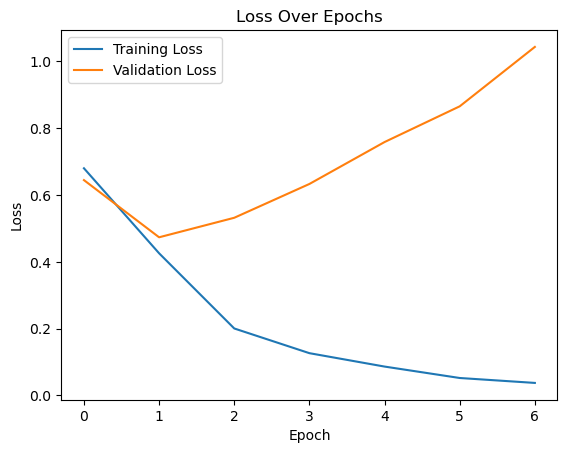

In [59]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

In [60]:
# Save the trained model
model.save('sentiment_model.keras')